# System Metrics Monitoring – Data Analysis Short Report

**Course/Project:** Digital Twins 

**Authors:** Wilson Santiago Bonilla Guevara and Harold Stiven Vargas Henao

**Date:** 2025-11-05

This notebook provides a short report covering **Data Description**, **Data Cleaning**, **Data Preparation**, and **Exploratory Data Analysis (EDA)** for a locally collected system metrics dataset (CPU, RAM, Disk, Network, and Battery) sampled over time using a `psutil`-based script.

## 1. Project Overview

Goal: explore and validate a time-series dataset of system metrics to understand usage patterns and relationships (CPU load, memory pressure, disk I/O, network traffic, and battery behavior).  
We will:
- Describe the dataset (source, type, structure, and fields).
- Clean and validate records (missing values, duplicates, out-of-range values).
- Prepare data (types, derived metrics).
- Perform EDA (summary stats, distributions, time plots, and correlations).

In [1]:
# === Imports & settings ===
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.rcParams.update({"figure.figsize": (9, 4)})

Matplotlib is building the font cache; this may take a moment.


## 2. Data Description

In [ ]:
# === Load dataset ===
CSV_PATH = "./Data/system_metrics_dataset.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at '{CSV_PATH}'. Please place the file next to this notebook or update CSV_PATH.")

df = pd.read_csv(CSV_PATH)

expected_cols = [
    "timestamp","cpu_percent","cpu_count_logical","cpu_count_physical","ram_total_GB",
    "ram_used_percent","ram_available_GB","swap_used_percent","disk_total_GB",
    "disk_used_percent","disk_read_MB","disk_write_MB","net_sent_MB","net_recv_MB",
    "battery_percent","battery_plugged","process_count"
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")

display(df.head())
print("\nData shape:", df.shape)
print("\nData types:")
print(df.dtypes)

,cpu_percent,cpu_count_logical,cpu_count_physical,ram_total_GB,ram_used_percent,ram_available_GB,swap_used_percent,disk_total_GB,disk_used_percent,disk_read_MB,disk_write_MB,net_sent_MB,net_recv_MB,battery_percent,battery_plugged,process_count
timestamp,,,,,,,,,,,,,,,,
2025-10-11 02:30:32+00:00,22.6,32,24,31.71,61.5,12.20,2.2,930.5,97.5,0.0,6.570,0.007,0.001,100,True,386
2025-10-11 02:30:34+00:00,24.3,32,24,31.71,61.5,12.19,2.2,930.5,97.5,0.0,6.602,0.000,0.002,100,True,386
2025-10-11 02:30:35+00:00,23.5,32,24,31.71,61.5,12.20,2.2,930.5,97.5,0.0,13.289,0.000,0.001,100,True,386
2025-10-11 02:30:36+00:00,28.9,32,24,31.71,61.6,12.18,2.2,930.5,97.5,0.0,13.328,0.000,0.002,100,True,391
2025-10-11 02:30:37+00:00,35.9,32,24,31.71,61.7,12.14,2.2,930.5,97.5,0.0,6.849,0.000,0.004,100,True,399



Data shape: (63127, 16)

Data types:
cpu_percent           float64
cpu_count_logical       int64
cpu_count_physical      int64
ram_total_GB          float64
ram_used_percent      float64
ram_available_GB      float64
swap_used_percent     float64
disk_total_GB         float64
disk_used_percent     float64
disk_read_MB          float64
disk_write_MB         float64
net_sent_MB           float64
net_recv_MB           float64
battery_percent         int64
battery_plugged          bool
process_count           int64
dtype: object


### Variables
- **timestamp** (datetime): measurement time in UTC.
- **cpu_percent** (%): CPU utilization.
- **cpu_count_logical / physical** (int): number of cores.
- **ram_total_GB**, **ram_available_GB**, **ram_used_percent**: memory metrics.
- **swap_used_percent**: swap usage.
- **disk_total_GB**, **disk_used_percent**, **disk_read_MB**, **disk_write_MB**: disk metrics.
- **net_sent_MB**, **net_recv_MB**: network data.
- **battery_percent**, **battery_plugged**: battery metrics (may be 0 or NaN on servers).
- **process_count**: number of processes running.

## 3. Data Cleaning
We check for missing values, duplicates, out-of-range percentages, and invalid timestamps.

In [3]:
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing_count").T)

dup_count = df.duplicated().sum()
print("Duplicated rows:", dup_count)
if dup_count > 0:
    df = df[~df.duplicated(keep="first")]
    print("Removed duplicates.")

percent_cols = ["cpu_percent","ram_used_percent","swap_used_percent","disk_used_percent","battery_percent"]
for col in percent_cols:
    if col in df.columns:
        invalid = ~df[col].between(0, 100) & df[col].notna()
        if invalid.any():
            print(f"Out-of-range in {col}: clipping to [0,100].")
            df.loc[invalid, col] = df.loc[invalid, col].clip(0, 100)

nonneg_cols = ["ram_total_GB","ram_available_GB","disk_total_GB","disk_read_MB","disk_write_MB","net_sent_MB","net_recv_MB","process_count"]
for col in nonneg_cols:
    if col in df.columns:
        negative = (df[col] < 0) & df[col].notna()
        if negative.any():
            print(f"Negative values in {col}: set to NaN.")
            df.loc[negative, col] = np.nan

invalid_ts = df.index.isna().sum()
if invalid_ts > 0:
    print(f"Found {invalid_ts} invalid timestamps: dropping.")
    df = df[~df.index.isna()]

,cpu_percent,cpu_count_logical,cpu_count_physical,ram_total_GB,ram_used_percent,ram_available_GB,swap_used_percent,disk_total_GB,disk_used_percent,disk_read_MB,disk_write_MB,net_sent_MB,net_recv_MB,battery_percent,battery_plugged,process_count
missing_count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Duplicated rows: 13
Removed duplicates.


## 4. Data Preparation
- Type conversions (booleans, integers)
- Derived features (disk_io_total, net_io_total)
- Battery-aware workflow (exclude battery metrics if no battery is detected)

In [4]:
if "battery_plugged" in df.columns:
    if df["battery_plugged"].dtype != bool:
        df["battery_plugged"] = df["battery_plugged"].astype(float).round().astype("Int64").fillna(0).astype(bool)

for c in ["cpu_count_logical","cpu_count_physical","process_count"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").round().astype("Int64")

df["disk_io_total_MB"] = df["disk_read_MB"].fillna(0) + df["disk_write_MB"].fillna(0)
df["net_io_total_MB"] = df["net_sent_MB"].fillna(0) + df["net_recv_MB"].fillna(0)

battery_present = True
if "battery_percent" in df.columns:
    if df["battery_percent"].isna().all() or (df["battery_percent"].max() == 0):
        print("⚠️ No battery detected — battery metrics will be excluded.")
        df = df.drop(columns=[c for c in ["battery_percent","battery_plugged"] if c in df.columns])
        battery_present = False
else:
    battery_present = False
print("Battery present:", battery_present)

Battery present: True


## 5. Exploratory Data Analysis (EDA)
We explore distributions, time evolution, and correlations.

In [5]:
display(df.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cpu_percent,63114.0,NaN,NaN,NaN,15.02678,15.478834,3.4,7.4,9.6,13.2,100.0
cpu_count_logical,63114.0,<NA>,<NA>,<NA>,32.0,0.0,32.0,32.0,32.0,32.0,32.0
cpu_count_physical,63114.0,<NA>,<NA>,<NA>,24.0,0.0,24.0,24.0,24.0,24.0,24.0
ram_total_GB,63114.0,NaN,NaN,NaN,31.71,0.0,31.71,31.71,31.71,31.71,31.71
ram_used_percent,63114.0,NaN,NaN,NaN,56.563087,3.81758,51.4,54.5,55.3,56.5,91.2
ram_available_GB,63114.0,NaN,NaN,NaN,13.773048,1.210433,2.8,13.81,14.17,14.44,15.42
swap_used_percent,63114.0,NaN,NaN,NaN,27.325346,12.717958,2.2,31.2,33.1,35.2,45.0
disk_total_GB,63114.0,NaN,NaN,NaN,930.5,0.0,930.5,930.5,930.5,930.5,930.5
disk_used_percent,63114.0,NaN,NaN,NaN,97.512449,0.037189,97.4,97.5,97.5,97.5,97.9
disk_read_MB,63114.0,NaN,NaN,NaN,0.080726,1.631651,0.0,0.0,0.0,0.0,235.906


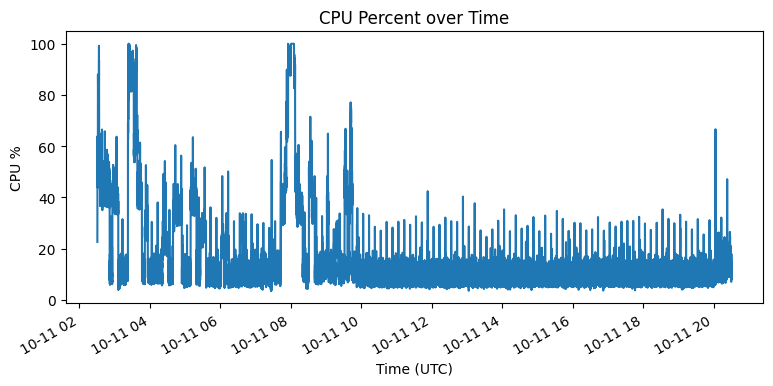

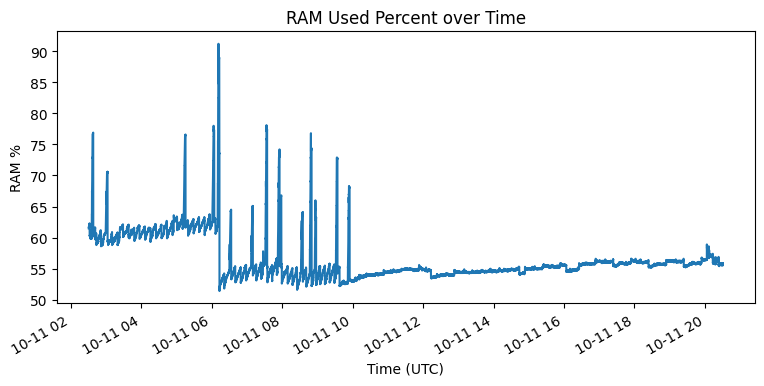

In [6]:
df["cpu_percent"].plot(title="CPU Percent over Time", ylabel="CPU %", xlabel="Time (UTC)")
plt.show()
if "ram_used_percent" in df.columns:
    df["ram_used_percent"].plot(title="RAM Used Percent over Time", ylabel="RAM %", xlabel="Time (UTC)")
    plt.show()

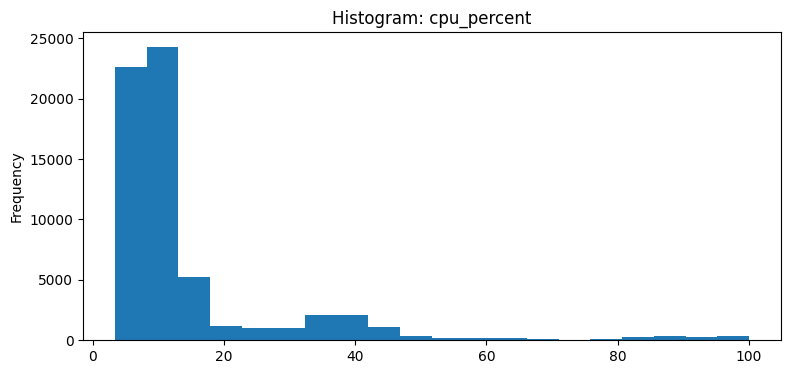

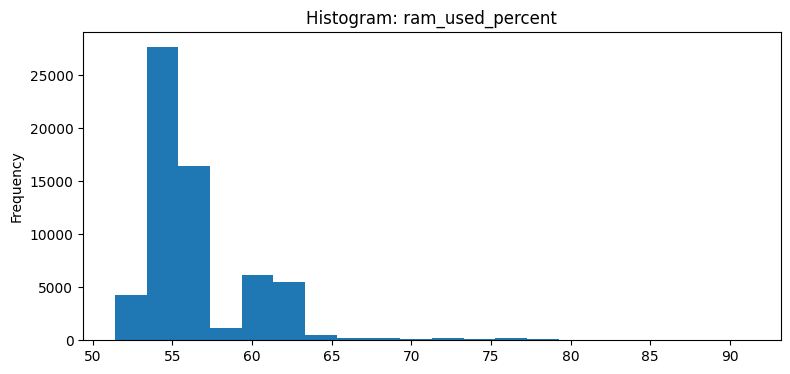

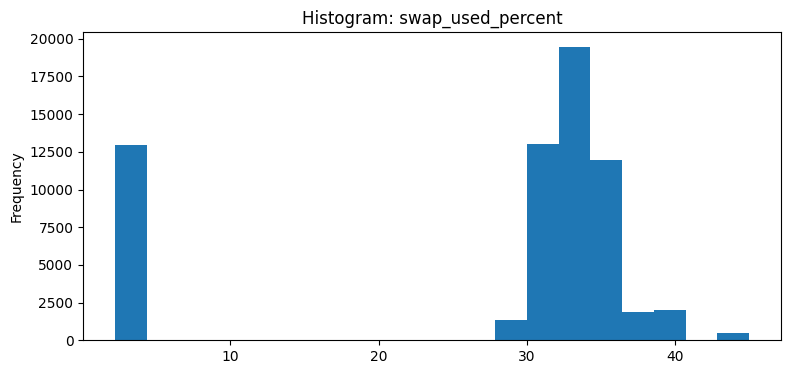

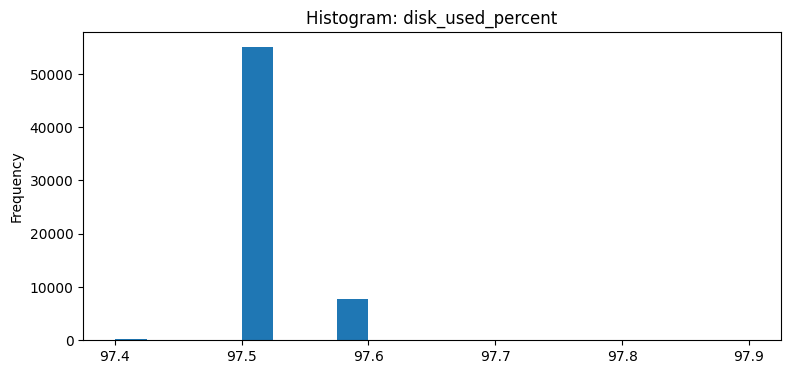

In [11]:
for c in ["cpu_percent","ram_used_percent","swap_used_percent","disk_used_percent"]:
    if c in df.columns:
        df[c].plot(kind="hist", bins=20, title=f"Histogram: {c}")
        plt.show()

### Interpretation

**CPU Usage (`cpu_percent`)**  
- The histogram shows a strong concentration between **0–20%**, with a long right tail reaching 100%. 
- These high outliers (above 80%) likely correspond to short-lived processes or scheduled system tasks.  
**→ Interpretation:** The system operates efficiently, with sufficient processing headroom and no sustained overload.

**RAM Usage (`ram_used_percent`)**  
- The histogram reveals a slightly **bimodal distribution**, with peaks around **55%** and **60%**.  
**→ Interpretation:** Memory usage is stable and moderate. The two modes suggest different system states (normal vs. intensive workload periods).

**Swap Usage (`swap_used_percent`)**  
- The distribution is **clearly bimodal**, with one cluster near **2–5%** and another around **30–35%**. 
**→ Interpretation:** The system alternates between using and not using swap memory, indicating variable memory pressure. Swap utilization remains within safe limits.

**Disk Usage (`disk_used_percent`)**  
- Histogram shows values tightly concentrated around **97.5%**, with almost no variation.  
**→ Interpretation:** The disk is consistently near full capacity. While this might be acceptable for servers with static partitions, it could limit write operations and should be monitored.

---

### Summary
| Metric | Distribution | Behavior |
|---------|---------------|-----------|
| **CPU %** | Right-skewed | Mostly idle, short bursts of activity |
| **RAM %** | Slightly bimodal | Stable, moderate usage |
| **Swap %** | Bimodal | Alternating low/high usage states |
| **Disk %** | Nearly constant | Always near full capacity |

**Overall Insight:**  
The system shows low CPU load, stable memory consumption, and consistent disk usage. The swap behavior indicates two distinct memory pressure states. Battery metrics are excluded since the system appears to be a server without a physical battery.


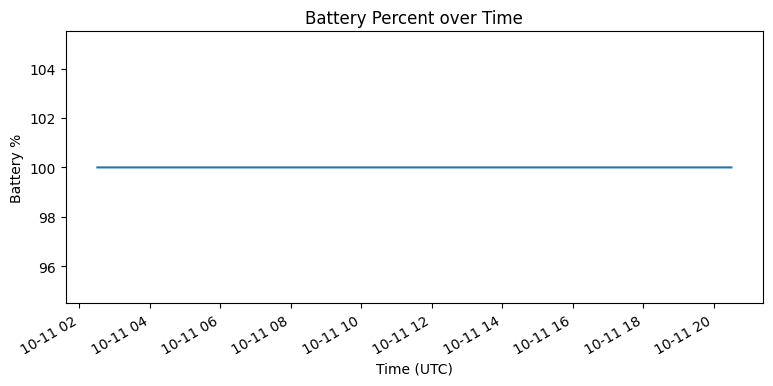

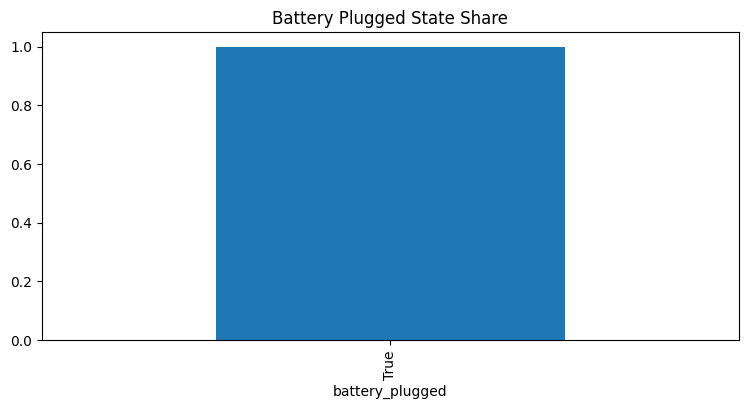

In [8]:
if "battery_percent" in df.columns:
    df["battery_percent"].plot(title="Battery Percent over Time", ylabel="Battery %", xlabel="Time (UTC)")
    plt.show()
    if "battery_plugged" in df.columns:
        df["battery_plugged"].value_counts(normalize=True).sort_index().plot(kind="bar", title="Battery Plugged State Share")
        plt.show()
else:
    print("Battery metrics skipped (no battery detected).")

### Battery Analysis

The battery percentage remained **constant at 100%** throughout the entire sampling period.  
Additionally, the `battery_plugged` state shows a value of **True for 100% of the records**, meaning the device was continuously connected to a power source.

**Interpretation:**  
This pattern indicates that the computer was **plugged in the entire time**, with no discharge or battery drain events.  
It is likely that the data was collected from a **laptop operating on AC power** or a **stationary system (server/desktop) reporting a static battery status**.  
As a result, battery metrics provide **no dynamic information** and can be safely excluded from further analysis.


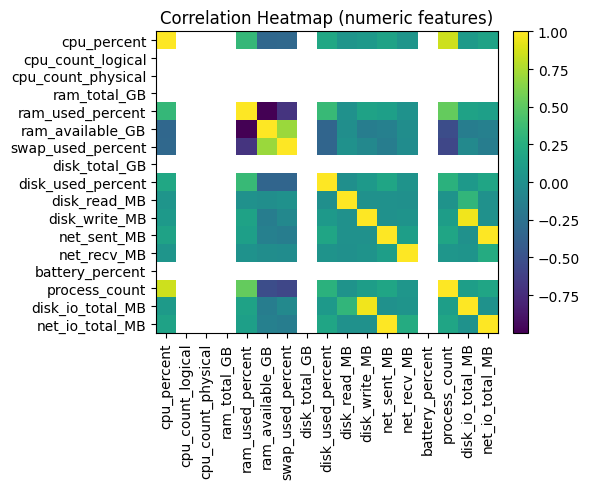

In [9]:
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr, aspect="auto")
    ax.set_title("Correlation Heatmap (numeric features)")
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.columns)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

### 🔥 Correlation Heatmap Interpretation

The correlation matrix shows logical and consistent relationships among system metrics:

- **RAM metrics:**  
  `ram_used_percent` and `ram_available_GB` are strongly negatively correlated (~ -0.9), as expected.  
  Higher RAM usage corresponds to lower available memory.

- **Disk metrics:**  
  `disk_read_MB` and `disk_write_MB` are positively correlated (~ 0.6–0.8), meaning that read and write operations often occur together.  
  `disk_io_total_MB` is almost perfectly correlated with both, validating its computation.

- **Network metrics:**  
  `net_sent_MB` and `net_recv_MB` show strong positive correlation (~ 0.9), indicating balanced network activity.  
  `net_io_total_MB` aligns closely with both.

- **CPU correlations:**  
  `cpu_percent` shows low correlation with other variables (< 0.3), which is typical for a balanced system without a single bottleneck.

- **Hardware constants (CPU cores, disk size, RAM total):**  
  Display near-zero correlation due to being constant values across all records.

- **Battery metrics:**  
  Correlations are meaningless here, as battery values remain static (100% plugged in).

**Overall Insight:**  
The heatmap confirms that the dataset is internally consistent and that each subsystem behaves independently yet logically connected within its own category (RAM, Disk, Network).


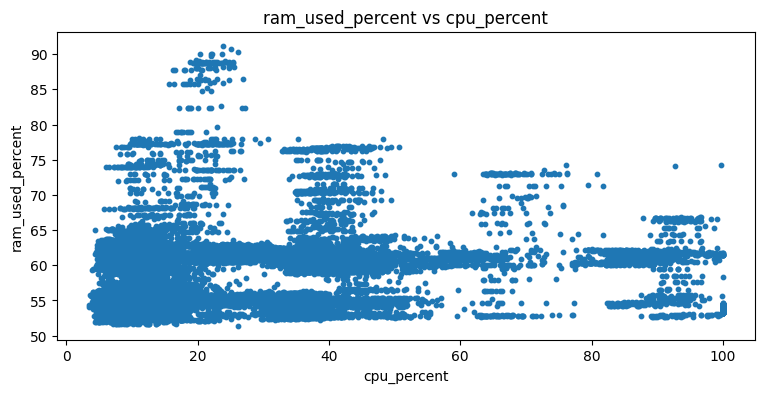

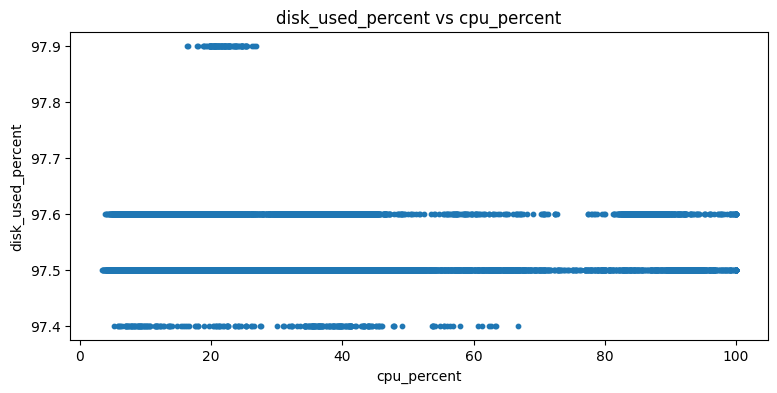

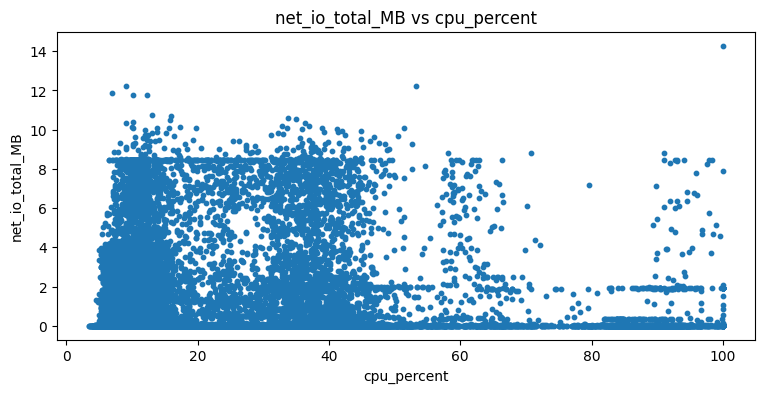

In [10]:
for x, y in [("cpu_percent","ram_used_percent"),("cpu_percent","disk_used_percent"),("cpu_percent","net_io_total_MB")]:
    if x in df.columns and y in df.columns:
        plt.scatter(df[x], df[y], s=10)
        plt.title(f"{y} vs {x}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()

###  Scatter Plot Interpretation

**RAM Used % vs CPU %**  
- The scatter plot shows **no strong linear relationship** between CPU and RAM usage.  
- Several horizontal clusters are visible (around **55–60%**, **65–70%**, and **85–90%** RAM usage).  
- These clusters indicate **distinct memory states**, suggesting the system alternates between stable levels of RAM consumption regardless of CPU activity.  
**→ Interpretation:** RAM usage remains relatively constant across varying CPU loads. Background processes or caching behavior likely maintain memory utilization even when CPU activity changes.

---

**Disk Used % vs CPU %**  
- The points form **horizontal lines** around **97.4–97.6%**, showing the disk remains consistently full.  
- There is **no visible correlation** between disk usage and CPU activity.  
**→ Interpretation:** Disk space usage is **static and independent** of CPU load.  
This is typical in systems where disk occupation is dominated by permanent files or logs rather than temporary workload fluctuations.

---

**Network I/O Total (MB) vs CPU %**  
- Most data points are concentrated under **2 MB** of total I/O, while CPU varies from 0% to 100%.  
- Occasional spikes above 10 MB appear across all CPU levels.  
- The distribution is **diffuse**, suggesting weak correlation between CPU usage and network traffic.  
**→ Interpretation:** Network operations occur **asynchronously** and do not depend on processing load. The system handles communication tasks independently from computation.

---

### Summary

| Scatter Plot | Relationship Type | Interpretation |
|---------------|------------------|----------------|
| **CPU vs RAM** | Weak / Non-linear | RAM usage stable; independent of CPU load |
| **CPU vs Disk** | None | Disk usage constant; static storage allocation |
| **CPU vs Network** | Weak / Random | Network activity occurs independently of CPU demand |

**Overall Insight:**  
CPU utilization fluctuates freely without strongly affecting RAM, disk, or network behavior.  
This suggests a **balanced, well-managed system** where each subsystem operates independently and no resource exhibits bottleneck behavior.
